In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.9/246.9 kB 7.6 MB/s eta 0:00:00


In [3]:
deps = [
    "pandas",
    "numpy",
    "lightgbm",
    "optuna",
    "scikit-learn",
    "imblearn",
    "joblib",
    "matplotlib"
]

import pkg_resources
with open("/content/drive/MyDrive/Datathon 2025 (HidupJ0kow1)/requirements_2.txt", "w") as f:
    for pkg in deps:
        try:
            v = pkg_resources.get_distribution(pkg).version
            f.write(f"{pkg}=={v}\n")
        except:
            pass

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import f1_score, recall_score, roc_auc_score

In [ ]:
!python --version

Python 3.11.13


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Datathon 2025 (HidupJ0kow1)/Dataset/preprocess/train_df.csv')

### **Data Visz**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2057312 entries, 0 to 2057311
Data columns (total 61 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   sport                     int64  
 1   dsport                    int64  
 2   dur                       float64
 3   sbytes                    int64  
 4   dbytes                    int64  
 5   sttl                      int64  
 6   dttl                      int64  
 7   sload                     float64
 8   dload                     float64
 9   spkts                     int64  
 10  swin                      int64  
 11  stcpb                     int64  
 12  dtcpb                     int64  
 13  smeansz                   int64  
 14  dmeansz                   int64  
 15  trans_depth               int64  
 16  res_bdy_len               int64  
 17  sjit                      float64
 18  djit                      float64
 19  sintpkt                   float64
 20  dintpkt                 

In [ ]:
data.head()

,sport,dsport,dur,sbytes,dbytes,sttl,dttl,sload,dload,spkts,...,mean_pkt_size,tcp_seq_diff,service_src_ratio,service_dst_ratio,res_bdy_rate,stime_hour,stime_weekday,ltime_hour,ltime_weekday,attack_cat_enc
0,57672,3260,0.285356,986,86,62,252,2.304490e+04,1205.511719,6,...,103.5,-3131431534,3.333322e+00,2.666658e+00,0.0,1,2,1,2,5
1,38052,6881,0.314311,1540,1644,31,29,3.675341e+04,39527.730470,16,...,93.5,-2172658546,1.400000e+06,6.000000e+05,0.0,9,2,9,2,5
2,42911,38558,0.301180,536,304,31,29,1.067800e+04,6056.178711,4,...,105.0,0,9.000000e+05,1.600000e+06,0.0,13,3,13,3,5
3,47439,53,0.000009,114,0,254,0,5.066666e+07,0.000000,2,...,28.5,0,1.649992e+01,1.649992e+01,0.0,9,2,9,2,4
4,61544,53,0.001079,146,178,31,29,5.412419e+05,659870.250000,2,...,81.0,0,2.000000e+05,2.000000e+05,0.0,7,2,7,2,5


In [ ]:
data['label'].value_counts()

,count
label,
0,1959668
1,97644


In [ ]:
data['attack_cat_enc'].value_counts()

,count
attack_cat_enc,
5,1959668
2,31268
4,25378
3,21792
6,13357
0,2184
1,1983
7,1511
8,171


In [ ]:
missing_values = data.isnull().sum()

missing_values = missing_values[missing_values > 0]

print("Missing values per kolom:")
print(missing_values)

Missing values per kolom:
Series([], dtype: int64)


In [ ]:
missing_values = data.isnull().sum()

missing_percent = data.isnull().mean() * 100

missing = pd.concat([missing_values, missing_percent], axis=1)
missing.columns = ['Jumlah Missing', 'Persen']
missing = missing[missing['Jumlah Missing'] > 0]
print(missing)

Empty DataFrame
Columns: [Jumlah Missing, Persen]
Index: []


In [ ]:
df_label = data.copy()

data_label = df_label.drop(columns=['attack_cat_enc'])
data_attack = data[data['attack_cat_enc'] != 5].drop(columns=['label'])

### **Deteksi Serangan (1/0)**

In [ ]:
data_label.head()

,sport,dsport,dur,sbytes,dbytes,sttl,dttl,sload,dload,spkts,...,pkt_jit_interaction_src,mean_pkt_size,tcp_seq_diff,service_src_ratio,service_dst_ratio,res_bdy_rate,stime_hour,stime_weekday,ltime_hour,ltime_weekday
0,57672,3260,0.285356,986,86,62,252,2.304490e+04,1205.511719,6,...,21969.374292,103.5,-3131431534,3.333322e+00,2.666658e+00,0.0,1,2,1,2
1,38052,6881,0.314311,1540,1644,31,29,3.675341e+04,39527.730470,16,...,22169.982080,93.5,-2172658546,1.400000e+06,6.000000e+05,0.0,9,2,9,2
2,42911,38558,0.301180,536,304,31,29,1.067800e+04,6056.178711,4,...,467.711532,105.0,0,9.000000e+05,1.600000e+06,0.0,13,3,13,3
3,47439,53,0.000009,114,0,254,0,5.066666e+07,0.000000,2,...,0.000000,28.5,0,1.649992e+01,1.649992e+01,0.0,9,2,9,2
4,61544,53,0.001079,146,178,31,29,5.412419e+05,659870.250000,2,...,0.000000,81.0,0,2.000000e+05,2.000000e+05,0.0,7,2,7,2


In [ ]:
X_label = data_label.drop(columns=['label'])
y_label = data_label['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_label, y_label, test_size=0.2, random_state=42, stratify=y_label)

In [ ]:
def evaluate_binary_model(model, X_train, y_train, X_test, y_test):
    print("==== Evaluasi pada Binary Data Training ====")
    y_train_pred = model.predict(X_train)
    y_train_prob = model.predict_proba(X_train)[:, 1]  # Probabilitas class 1
    print(f"F1-score (class 1): {f1_score(y_train, y_train_pred, pos_label=1):.4f}")
    print(f"Recall (class 1):   {recall_score(y_train, y_train_pred, pos_label=1):.4f}")
    print(f"ROC-AUC score:      {roc_auc_score(y_train, y_train_prob):.4f}")

    print("\n==== Evaluasi pada Binary Data Testing ====")
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)[:, 1]
    print(f"F1-score (class 1): {f1_score(y_test, y_test_pred, pos_label=1):.4f}")
    print(f"Recall (class 1):   {recall_score(y_test, y_test_pred, pos_label=1):.4f}")
    print(f"ROC-AUC score:      {roc_auc_score(y_test, y_test_prob):.4f}")

**Optuna Param Tuning**

In [ ]:
def objective(trial):
    max_depth = trial.suggest_int("max_depth", 3, 8)
    max_leaves = min(200, 2 ** max_depth)
    min_leaves = min(max_leaves, 2 ** (max_depth - 1))

    param = {
        "objective": "binary",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "random_state": 42,
        "n_jobs": -1,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", min_leaves, max_leaves),
        "max_depth": max_depth,
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 5),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "scale_pos_weight": scale_pos_weight,
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []
    recall_scores = []
    roc_auc_scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        X_tr, X_val_ = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val_ = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = lgb.LGBMClassifier(n_estimators=1000, **param)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val_, y_val_)],
            eval_metric="binary_logloss",
            callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
        )

        y_pred = model.predict(X_val_)
        y_proba = model.predict_proba(X_val_)[:, 1]  # diperlukan untuk ROC AUC

        f1 = f1_score(y_val_, y_pred, pos_label=1)
        recall = recall_score(y_val_, y_pred, pos_label=1)
        auc = roc_auc_score(y_val_, y_proba)

        print(f"Fold {fold+1} — F1: {f1:.4f} | Recall: {recall:.4f} | ROC AUC: {auc:.4f}")

        f1_scores.append(f1)
        recall_scores.append(recall)
        roc_auc_scores.append(auc)

    trial.set_user_attr("recall_macro", np.mean(recall_scores))
    trial.set_user_attr("roc_auc", np.mean(roc_auc_scores))

    return np.mean(f1_scores)

In [ ]:
db_path = "/content/drive/MyDrive/Datathon 2025 (HidupJ0kow1)/Dataset/optuna/optuna_study.db"

neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

study = optuna.create_study(
    study_name="lgbm_f1score_optuna_no_pruner",
    direction='maximize',
    storage=f"sqlite:///{db_path}",
    load_if_exists=True
)

study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2025-07-06 06:03:11,682] A new study created in RDB with name: lgbm_f1score_optuna_no_pruner


  0%|          | 0/100 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[158]	valid_0's binary_logloss: 0.033911
Fold 1 — F1: 0.8690 | Recall: 1.0000 | ROC AUC: 0.9991
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[158]	valid_0's binary_logloss: 0.033412
Fold 2 — F1: 0.8709 | Recall: 0.9999 | ROC AUC: 0.9991
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[158]	valid_0's binary_logloss: 0.0331821
Fold 3 — F1: 0.8717 | Recall: 0.9998 | ROC AUC: 0.9992
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[158]	valid_0's binary_logloss: 0.0339475
Fold 4 — F1: 0.8675 | Recall: 1.0000 | ROC AUC: 0.9992
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[158]	valid_0's binary_logloss: 0.0336918
Fold 5 — F1: 0.8690 | Recall: 0.9999 | ROC AUC: 0.9991
[I 2025-07-06 06:06:51,769] Trial 0 f

In [ ]:
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

study = optuna.load_study(
    study_name="lgbm_f1score_optuna_no_pruner",
    storage = "sqlite:////content/drive/MyDrive/Datathon 2025 (HidupJ0kow1)/Dataset/optuna/optuna_study.db"
)
study.optimize(objective, n_trials=26, show_progress_bar=True)

  0%|          | 0/26 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's binary_logloss: 0.01896
Fold 1 — F1: 0.9226 | Recall: 0.9713 | ROC AUC: 0.9994
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's binary_logloss: 0.018617
Fold 2 — F1: 0.9239 | Recall: 0.9709 | ROC AUC: 0.9994
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.0182993
Fold 3 — F1: 0.9252 | Recall: 0.9698 | ROC AUC: 0.9994
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.018713
Fold 4 — F1: 0.9230 | Recall: 0.9713 | ROC AUC: 0.9994
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[979]	valid_0's binary_logloss: 0.0186087
Fold 5 — F1: 0.9229 | Recal

In [ ]:
import json

with open("/content/drive/MyDrive/Datathon 2025 (HidupJ0kow1)/Dataset/optuna/lgbm_params.json", "w") as f:
    json.dump(study.best_trial.params, f)

In [ ]:
print("Best trial:")
print("  Balanced Accuracy:", study.best_value)
print("  Best Params:")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")

Best trial:
  Balanced Accuracy: 0.929561435050476
  Best Params:
    max_depth: 8
    learning_rate: 0.1275459354943838
    num_leaves: 172
    min_child_samples: 18
    feature_fraction: 0.875912543620382
    bagging_fraction: 0.8941517886155228
    bagging_freq: 3
    colsample_bytree: 0.9385213627410153
    subsample_freq: 5
    lambda_l1: 1.2233254749952467
    lambda_l2: 0.011826588193740217


In [ ]:
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

best_params = study.best_params
best_params.update({
    "objective": "binary",
    "random_state": 42,
    "scale_pos_weight": scale_pos_weight,
    "n_jobs": -1
})

lgbm_bin = lgb.LGBMClassifier(
    n_estimators=1000,
    **best_params
)

lgbm_bin.fit(X_train, y_train,
                   eval_set=[(X_test, y_test)],
                   eval_metric="auc",
                   callbacks=[lgb.early_stopping(50), lgb.log_evaluation(10)])
evaluate_binary_model(lgbm_bin, X_train, y_train, X_test, y_test)

Training until validation scores don't improve for 50 rounds
[10]	valid_0's auc: 0.999103	valid_0's binary_logloss: 0.0415815
[20]	valid_0's auc: 0.999201	valid_0's binary_logloss: 0.0335322
[30]	valid_0's auc: 0.999235	valid_0's binary_logloss: 0.0334222
[40]	valid_0's auc: 0.99926	valid_0's binary_logloss: 0.0329073
[50]	valid_0's auc: 0.999286	valid_0's binary_logloss: 0.0325247
[60]	valid_0's auc: 0.999295	valid_0's binary_logloss: 0.0321654
[70]	valid_0's auc: 0.99931	valid_0's binary_logloss: 0.0312742
[80]	valid_0's auc: 0.999329	valid_0's binary_logloss: 0.0301806
[90]	valid_0's auc: 0.999339	valid_0's binary_logloss: 0.0291506
[100]	valid_0's auc: 0.99935	valid_0's binary_logloss: 0.0282828
[110]	valid_0's auc: 0.999357	valid_0's binary_logloss: 0.0275581
[120]	valid_0's auc: 0.999359	valid_0's binary_logloss: 0.0269725
[130]	valid_0's auc: 0.999369	valid_0's binary_logloss: 0.026257
[140]	valid_0's auc: 0.999374	valid_0's binary_logloss: 0.0257073
[150]	valid_0's auc: 0.99937

In [ ]:
import joblib

joblib.dump(lgbm_bin, '/content/drive/MyDrive/Datathon 2025 (HidupJ0kow1)/Model/lgbm_binary_model.pkl')

['/content/drive/MyDrive/Datathon 2025 (HidupJ0kow1)/Model/lgbm_binary_model.pkl']

### **Deteksi Jenis Serangan**

In [ ]:
data_attack.head()

,sport,dsport,dur,sbytes,dbytes,sttl,dttl,sload,dload,spkts,...,mean_pkt_size,tcp_seq_diff,service_src_ratio,service_dst_ratio,res_bdy_rate,stime_hour,stime_weekday,ltime_hour,ltime_weekday,attack_cat_enc
3,47439,53,0.000009,114,0,254,0,5.066666e+07,0.00,2,...,28.5,0,16.499918,16.499918,0.0,9,2,9,2,4
7,39299,58278,0.815515,364,1248,62,252,3.129311e+03,10712.25,8,...,101.0,-798193623,0.999990,0.999990,0.0,12,3,12,3,2
9,47439,53,0.000001,114,0,254,0,4.560000e+08,0.00,2,...,28.5,0,6.999965,6.999965,0.0,1,2,1,2,4
34,54965,111,0.000008,168,0,254,0,8.400000e+07,0.00,2,...,42.0,0,1.999990,0.499998,0.0,11,2,11,2,6
37,1043,53,0.000003,114,0,254,0,1.520000e+08,0.00,2,...,28.5,0,21.999890,17.999910,0.0,3,2,3,2,4


In [ ]:
X_att = data_attack.drop(columns=['attack_cat_enc'])
y_att = data_attack['attack_cat_enc']

In [ ]:
X_train_att, X_test_att, y_train_att, y_test_att = train_test_split(X_att, y_att, test_size=0.2, random_state=42, stratify=y_att)

In [ ]:
print(X_att.columns.tolist())

['sport', 'dsport', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sload', 'dload', 'spkts', 'swin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'sjit', 'djit', 'sintpkt', 'dintpkt', 'tcprtt', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src__ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'duration', 'src_bps', 'dst_bps', 'src_pps', 'byte_ratio', 'pkt_ratio', 'jit_ratio', 'loss_ratio_src', 'loss_ratio_dst', 'window_ratio', 'total_bytes', 'total_pkts', 'byte_pkt_interaction_src', 'byte_pkt_interaction_dst', 'load_jit_interaction_src', 'load_jit_interaction_dst', 'pkt_jit_interaction_src', 'mean_pkt_size', 'tcp_seq_diff', 'service_src_ratio', 'service_dst_ratio', 'res_bdy_rate', 'stime_hour', 'stime_weekday', 'ltime_hour', 'ltime_weekday']


In [ ]:
from imblearn.over_sampling import SMOTENC
from collections import Counter

categorical_cols = [
    'is_sm_ips_ports',
    'ct_state_ttl',
    'ct_flw_http_mthd',
    'is_ftp_login',
    'stime_hour',
    'stime_weekday',
    'ltime_hour',
    'ltime_weekday'
]

categorical_features = [X_att.columns.get_loc(col) for col in categorical_cols]

smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)
X_train_smt, y_train_smt = smote_nc.fit_resample(X_train_att, y_train_att)

print("Distribusi setelah SMOTENC:", Counter(y_train_smt))

Distribusi setelah SMOTENC: Counter({4: 25014, 2: 25014, 6: 25014, 3: 25014, 8: 25014, 0: 25014, 1: 25014, 7: 25014})


In [ ]:
from sklearn.metrics import f1_score, recall_score, classification_report, confusion_matrix

def evaluate_multiclass_model(model, X_train, y_train, X_test, y_test):
    print("==== Evaluasi pada Multi Class Data Training ====")
    y_train_pred = model.predict(X_train)
    print("F1-score (macro):", f1_score(y_train, y_train_pred, average='macro'))
    print("Recall (macro):  ", recall_score(y_train, y_train_pred, average='macro'))
    print("\nClassification Report (Train):")
    print(classification_report(y_train, y_train_pred))

    print("\n==== Evaluasi pada Multi Class Data Testing ====")
    y_test_pred = model.predict(X_test)
    print("F1-score (macro):", f1_score(y_test, y_test_pred, average='macro'))
    print("Recall (macro):  ", recall_score(y_test, y_test_pred, average='macro'))
    print("\nClassification Report (Test):")
    print(classification_report(y_test, y_test_pred))

**Optuna Param Tuning**

In [ ]:
def objective_multiclass(trial):
    num_class = y_train_att.nunique()

    max_depth = trial.suggest_int("max_depth", 3, 10)
    max_leaves = min(255, 2 ** max_depth)
    min_leaves = min(max_leaves, 2 ** (max_depth - 1))

    param = {
        "objective": "multiclass",
        "num_class": num_class,
        "verbosity": -1,
        "boosting_type": "gbdt",
        "random_state": 42,
        "n_jobs": -1,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", min_leaves, max_leaves),
        "max_depth": max_depth,
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 5),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "class_weight": "balanced"  # Tambahkan ini
    }

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_smt, y_train_smt)):
        X_tr, X_val = X_train_smt.iloc[train_idx], X_train_smt.iloc[val_idx]
        y_tr, y_val = y_train_smt.iloc[train_idx], y_train_smt.iloc[val_idx]

        model = lgb.LGBMClassifier(n_estimators=1000, **param)

        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric="multi_logloss",
            callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
        )

        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred, average="macro")
        f1_scores.append(f1)

        print(f"Fold {fold+1} — Macro F1: {f1:.4f}")

    return np.mean(f1_scores)

In [ ]:
study_multi = optuna.create_study(
    study_name="lgbm_multiclass_optuna",
    direction="maximize",
    storage="sqlite:////content/drive/MyDrive/Datathon 2025 (HidupJ0kow1)/Dataset/optuna/study_multiclass_classweight.db",
    load_if_exists=True
)

study_multi.optimize(objective_multiclass, n_trials=50, show_progress_bar=True)

[I 2025-07-08 10:32:08,210] A new study created in RDB with name: lgbm_multiclass_optuna


  0%|          | 0/50 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[229]	valid_0's multi_logloss: 0.327181
Fold 1 — Macro F1: 0.8734
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[198]	valid_0's multi_logloss: 0.333264
Fold 2 — Macro F1: 0.8711
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[236]	valid_0's multi_logloss: 0.330407
Fold 3 — Macro F1: 0.8714
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[231]	valid_0's multi_logloss: 0.320656
Fold 4 — Macro F1: 0.8735
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[241]	valid_0's multi_logloss: 0.326705
Fold 5 — Macro F1: 0.8727
[I 2025-07-08 10:36:47,635] Trial 0 finished with value: 0.8724104912754773 and parameters: {'max_depth': 6, 'learning_rate': 0.09268626071249818, 'num_leaves': 45, 'min_child_samples': 21, 

In [ ]:
study_multi = optuna.load_study(
    study_name="lgbm_multiclass_optuna",
    storage = "sqlite:////content/drive/MyDrive/Datathon 2025 (HidupJ0kow1)/Dataset/optuna/study_multiclass_classweight.db"
)
study_multi.optimize(objective_multiclass, n_trials=12, show_progress_bar=True)

  0%|          | 0/12 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[776]	valid_0's multi_logloss: 0.317699
Fold 1 — Macro F1: 0.8786
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[738]	valid_0's multi_logloss: 0.32357
Fold 2 — Macro F1: 0.8762
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[798]	valid_0's multi_logloss: 0.320848
Fold 3 — Macro F1: 0.8775
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[807]	valid_0's multi_logloss: 0.310738
Fold 4 — Macro F1: 0.8785
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[809]	valid_0's multi_logloss: 0.317656
Fold 5 — Macro F1: 0.8781
[I 2025-07-08 23:48:48,282] Trial 39 finished with value: 0.8777900779468464 and parameters: {'max_depth': 10, 'learning_rate': 0.018171726405778944, 'num_leaves': 255, 'min_child_samples': 9

In [ ]:
import json

with open("/content/drive/MyDrive/Datathon 2025 (HidupJ0kow1)/Dataset/optuna/lgbm_params_multi_classweight.json", "w") as f:
    json.dump(study_multi.best_trial.params, f)

In [ ]:
import json

with open("/content/drive/MyDrive/Datathon 2025 (HidupJ0kow1)/Dataset/optuna/lgbm_params_multi_classweight.json", "r") as f:
    best_params_multi = json.load(f)

In [ ]:
# best_params_multi = study_multi.best_params
best_params_multi.update({
    "objective": "multiclass",
    "num_class": y_train_smt.nunique(),
    "random_state": 42,
    "n_jobs": -1,
})

lgbm_multi = lgb.LGBMClassifier(n_estimators=1000, **best_params_multi)

lgbm_multi.fit(
    X_train_smt, y_train_smt,
    eval_set=[(X_test_att, y_test_att)],
    eval_metric="multi_logloss",
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(10)]
)

evaluate_multiclass_model(lgbm_multi, X_train_smt, y_train_smt, X_test_att, y_test_att)

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=2 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8874411914534995, colsample_bytree=0.8037708908851157 will be ignored. Current value: feature_fraction=0.8874411914534995
[LightGBM] [Warning] lambda_l2 is set=0.17561238799173082, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17561238799173082
[LightGBM] [Warning] lambda_l1 is set=4.041308400564172, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.041308400564172
[LightGBM] [Warning] bagging_fraction is set=0.9792631181635699, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9792631181635699
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=2 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8874411914534995, colsample_bytree=0.8037708908851157 will be ignored. Current value: feature_fraction=0.8874411914534995
[LightGBM] [Warning] lambda_l2 i

In [ ]:
def predict_with_confidence(model, X, threshold=0.6):
    proba = model.predict_proba(X)
    max_confidence = np.max(proba, axis=1)
    preds = np.argmax(proba, axis=1)

    preds_with_unknown = np.where(max_confidence < threshold, -1, preds)

    return preds_with_unknown, max_confidence

In [ ]:
from sklearn.metrics import classification_report

y_pred, confidences = predict_with_confidence(lgbm_multi, X_test_att, threshold=0.6)

mask_valid = y_pred != -1
print(classification_report(y_test_att[mask_valid], y_pred[mask_valid]))

print("Total prediksi unknown:", np.sum(y_pred == -1))

              precision    recall  f1-score   support

           0       0.31      0.63      0.42       111
           1       0.35      0.59      0.44        70
           2       0.95      0.95      0.95      5579
           3       0.99      0.98      0.99      3983
           4       0.99      0.97      0.98      4687
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00      2254
           7       0.03      0.00      0.01       290
           8       0.00      0.00      0.00        29

    accuracy                           0.82     17003
   macro avg       0.40      0.46      0.42     17003
weighted avg       0.82      0.82      0.82     17003

Total prediksi unknown: 2526


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [ ]:
y_proba = lgbm_multi.predict_proba(X_test_att)

max_proba = y_proba.max(axis=1)

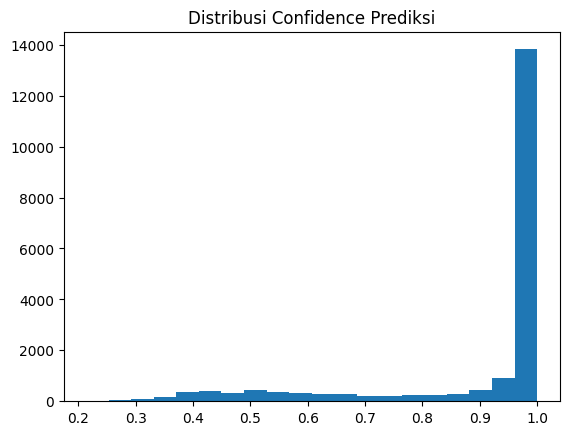

In [ ]:
import matplotlib.pyplot as plt
plt.hist(max_proba, bins=20)
plt.title("Distribusi Confidence Prediksi")
plt.show()

In [ ]:
import joblib

joblib.dump(lgbm_multi, '/content/drive/MyDrive/Datathon 2025 (HidupJ0kow1)/Model/lgbm_multiclass_model.pkl')

['/content/drive/MyDrive/Datathon 2025 (HidupJ0kow1)/Model/lgbm_multiclass_model.pkl']